![](nlfff.png)

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from sunpy.map import Map
from astropy.table import Table

In [144]:
class nlfff:

      def __init__(self,filename):
            self.filename=filename

            nc=netCDF4.Dataset(self.filename,'r')
            self.NOAA=nc.NOAA
            self.year_month_day_time=nc.year_month_day_time
            self.project=nc.project
            self.production_date=nc.production_date
            self.version=nc.version
            self.data_doi=nc.data_doi
            self.http_link=nc.http_link
            self.Distributor=nc.Distributor
            
            nc_x=nc.variables['x']
            self.x=nc_x[:]
            print(nc_x.long_name,' unit:',nc_x.units)
            nc_y=nc.variables['y']
            self.y=nc_y[:]
            print(nc_y.long_name,' unit:',nc_y.units)
            nc_z=nc.variables['z']
            self.z=nc_z[:]
            print(nc_z.long_name,' unit:',nc_z.units)
            
            nc_bx=nc.variables['Bx']
            self.bx=nc_bx[:].transpose(2,1,0)
            print(nc_bx.long_name,' unit:',nc_bx.units)
            nc_by=nc.variables['By']
            self.by=nc_by[:].transpose(2,1,0)
            print(nc_by.long_name,' unit:',nc_by.units)
            nc_bz=nc.variables['Bz']
            self.bz=nc_bz[:].transpose(2,1,0)
            print(nc_bz.long_name,' unit:',nc_bz.units)
            
            nc_bxp=nc.variables['Bx_pot']
            self.bx_pot=nc_bxp[:].transpose(2,1,0)
            print(nc_bxp.long_name,' unit:',nc_bxp.units)
            nc_byp=nc.variables['By_pot']
            self.by_pot=nc_byp[:].transpose(2,1,0)
            print(nc_byp.long_name,' unit:',nc_byp.units)
            nc_bzp=nc.variables['Bz_pot']
            self.bz_pot=nc_bzp[:].transpose(2,1,0)
            print(nc_bzp.long_name,' unit:',nc_bzp.units)
            
      def info(self):
            self.Lx_Mm=max(self.x) - min(self.x)
            self.Ly_Mm=max(self.y) - min(self.y)
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})\n')
            print(f"NOAA",self.NOAA)
            print(f'year_month_day_time',self.year_month_day_time)
            print(f"project",self.project)
            print(f"production_date",self.production_date)
            print(f"version",self.version)
            print(f"data_doi",self.data_doi)
            print(f"http_link",self.http_link)
            print(f"Distributor",self.Distributor)

      def plot(self):
            xs=12.0
            ys=4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))
            
            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.bx[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.by[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.bz[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')
            
            #plt.pause(0.1)
            # plt.savefig('./B.png')


In [145]:
data = nlfff('12673_20170905_202400.nc')

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


In [146]:
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

In [265]:
# class SPINN(nn.Module):
#     features: Sequence[int]

#     @nn.compact
#     def __call__(self, x, y, z):
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         bx = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
        
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         by = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
        
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         bz = jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
#         return jnp.stack([bx, by, bz], axis=0)

# class SPINN(nn.Module):
#     features: Sequence[int]

#     @nn.compact
#     def __call__(self, x, y, z):
#         inputs, outputs = [x, y, z], []
#         init = nn.initializers.glorot_normal()
#         for X in inputs:
#             for fs in self.features[:-1]:
#                 X = nn.Dense(fs, kernel_init=init)(X)
#                 X = nn.activation.tanh(X)
#             X = nn.Dense(self.features[-1], kernel_init=init)(X)
#             outputs += [jnp.transpose(X, (1, 0))]
#         xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
#         return jnp.einsum('fxy, fz->fxyz', xy, outputs[-1])

class SPINN(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.glorot_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                K = nn.Dense(fs, kernel_init=init)(X)
                K = nn.activation.tanh(K)
            K = nn.Dense(self.features[-1], kernel_init=init)(K)
            for fs in self.features[:-1]:
                L = nn.Dense(fs, kernel_init=init)(X)
                L = nn.activation.tanh(L)
            L = nn.Dense(self.features[-1], kernel_init=init)(L)
            for fs in self.features[:-1]:
                M = nn.Dense(fs, kernel_init=init)(X)
                M = nn.activation.tanh(M)
            M = nn.Dense(self.features[-1], kernel_init=init)(M)
            outputs += [[jnp.transpose(L, (1, 0)), jnp.transpose(K, (1, 0)), jnp.transpose(M, (1, 0))]]
        xy = jnp.einsum('fx, fy->fxy', outputs[0][0], outputs[1][0])
        bx = jnp.einsum('fxy, fz->xyz', xy, outputs[2][0])

        xy = jnp.einsum('fx, fy->fxy', outputs[0][1], outputs[1][1])
        by = jnp.einsum('fxy, fz->xyz', xy, outputs[2][1])

        xy = jnp.einsum('fx, fy->fxy', outputs[0][2], outputs[1][2])
        bz = jnp.einsum('fxy, fz->xyz', xy, outputs[2][2])
        return jnp.stack([bx, by, bz], axis=0)

@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

def train_data_generator(nc, key, b):
    keys = jax.random.split(key, 3)

    xc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=512)
    yc = jax.random.uniform(keys[1], (nc, 1), minval=0., maxval=256)
    zc = jax.random.uniform(keys[2], (nc, 1), minval=0., maxval=256)
    # xc_m, yc_m, zc_m = jnp.meshgrid(xc.ravel(), yc.ravel(), zc.ravel(), indexing='ij')
    # uc = jnp.zeros(xc_m.shape)

    # xb_p = jnp.arange(0, 513).reshape(-1, 1)
    # yb_p = jnp.arange(0, 257).reshape(-1, 1)
    # zb_p = jnp.arange(0, 257).reshape(-1, 1)

    # xb = [jnp.array([[0]]),
    #       jnp.array([[512]]),
    #       xb_p,
    #       xb_p,
    #       xb_p,
    #       xb_p,]
    # yb = [yb_p,
    #       yb_p,
    #       jnp.array([[0]]),
    #       jnp.array([[256]]),
    #       yb_p,
    #       yb_p,]
    # zb = [zb_p,
    #       zb_p,
    #       zb_p,
    #       zb_p,
    #       jnp.array([[0]]),
    #       jnp.array([[256]]),]

    # ub = [b[:, 0, :, :]]
    # ub += [b[:, 512, :, :]]
    # ub += [b[:, :, 0, :]]
    # ub += [b[:, :, 256, :]]
    # ub += [b[:, :, :, 0]]
    # ub += [b[:, :, :, 256]]


    xb_p = jax.random.randint(keys[3], (nc, 1), minval=0, maxval=512)
    yb_p = jax.random.randint(keys[4], (nc, 1), minval=0, maxval=256)
    zb_p = jax.random.randint(keys[5], (nc, 1), minval=0, maxval=256)

    xb = [jnp.array([[0]]),
          jnp.array([[512]]),
          xb_p,
          xb_p,
          xb_p,
          xb_p,]
    yb = [yb_p,
          yb_p,
          jnp.array([[0]]),
          jnp.array([[256]]),
          yb_p,
          yb_p,]
    zb = [zb_p,
          zb_p,
          zb_p,
          zb_p,
          jnp.array([[0]]),
          jnp.array([[256]]),]
    
    return xc, yc, zc, xb, yb, zb, b


def loss_nlfff(apply_fn, *train_data):
    def pde_loss(params, xc, yc, zc):
        v = jnp.ones(xc.shape)
        bx, bx_x = jvp(lambda x: apply_fn(params, x, yc, zc)[0, ...], (xc,), (v,))
        bx, bx_y = jvp(lambda y: apply_fn(params, xc, y, zc)[0, ...], (yc,), (v,))
        bx, bx_z = jvp(lambda z: apply_fn(params, xc, yc, z)[0, ...], (zc,), (v,))

        by, by_x = jvp(lambda x: apply_fn(params, x, yc, zc)[1, ...], (xc,), (v,))
        by, by_y = jvp(lambda y: apply_fn(params, xc, y, zc)[1, ...], (yc,), (v,))
        by, by_z = jvp(lambda z: apply_fn(params, xc, yc, z)[1, ...], (zc,), (v,))

        bz, bz_x = jvp(lambda x: apply_fn(params, x, yc, zc)[2, ...], (xc,), (v,))
        bz, bz_y = jvp(lambda y: apply_fn(params, xc, y, zc)[2, ...], (yc,), (v,))
        bz, bz_z = jvp(lambda z: apply_fn(params, xc, yc, z)[2, ...], (zc,), (v,))

        x_comp = ((bx_z - bz_x)*bz - (by_x-bx_y)*by)**2
        y_comp = ((by_x - bx_y)*bx - (bz_y-by_z)*bz)**2
        z_comp = ((bz_y - by_z)*by - (bx_z-bz_x)*bx)**2

        div = (bx_x + by_y + bz_z)**2
        return jnp.mean(div)
    
    def boundary_loss(params, xb, yb, zb, b):
        loss = 0.
        for i in range(6):
            b_nn = apply_fn(params, xb[i], yb[i], zb[i]).squeeze().ravel()
            xb_m, yb_m, zb_m = np.meshgrid(xb[i], yb[i], zb[i], indexing='ij')
            b_bc = b[:, xb_m.ravel(), yb_m.ravel(), zb_m.ravel()].ravel()/2500.
            loss += (1/6.)*jnp.mean((b_nn - b_bc)**2)

            # b_nn = apply_fn(params, xb[i], yb[i], zb[i]).squeeze()
            # b_bc = ub[i]
            # losses = (b_nn[0, ...] - b_bc[0, ...])**2 + (b_nn[1, ...] - b_bc[1, ...])**2 + (b_nn[2, ...] - b_bc[2, ...])**2
            # loss += (1/6.)*jnp.mean(losses)
            # loss += (1/6.)*jnp.mean((apply_fn(params, xb[i], yb[i], zb[i]).squeeze() - b[:, xb[i].ravel(), yb[i].ravel(), zb[i].ravel()])**2)
        return loss

    xc, yc, zc, xb, yb, zb, b = train_data 

    fn = lambda params: 1e6*pde_loss(params, xc, yc, zc) + (1/1000.)*boundary_loss(params, xb, yb, zb, b)
    return fn


In [266]:
NC = 64
NB = 64
NC_TEST = 100
SEED = 444
LR = 1e-4
EPOCHS = 1000
N_LAYERS = 4
FEATURES = 128
LOG_ITER = 100

In [267]:
key = jax.random.PRNGKey(SEED)

key, subkey = jax.random.split(key, 2)
# feat_sizes = list(FEATURES for _ in range(N_LAYERS)) + [3]
feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))
model = SPINN(feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optim = optax.adam(LR)
state = optim.init(params)

key, subkey = jax.random.split(key, 2)
b = np.stack([np.array(data.bx), np.array(data.by), np.array(data.bz)], axis=0)
train_data = train_data_generator(NC, subkey, b)
# xt, yt, zt = test_data_generator(NC_TEST)

apply_fn = jax.jit(model.apply)

In [268]:
EPOCHS = 5000
LOG_ITER = 1000

In [269]:
loss_fn = loss_nlfff(apply_fn, *train_data)
@jax.jit
def train_one_step(params, state):
    # compute loss and gradient
    loss, gradient = value_and_grad(loss_fn)(params)
    # update state
    params, state = update_model(optim, gradient, params, state)
    return loss, params, state

start = time.time()
for e in trange(1, EPOCHS+1):
    # single run
    loss, params, state = train_one_step(params, state)
    # if e % 100 == 0 and e < 1000:
        # u = apply_fn(params, xt, yt)
        # plot_u(xt_m, yt_m, u, e)
    if e % LOG_ITER == 0:
        print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}')
end = time.time()
print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

 20%|██        | 1006/5000 [00:32<01:35, 41.94it/s]

Epoch: 1000/5000 --> loss: 2.23789501


 40%|████      | 2004/5000 [00:56<01:15, 39.92it/s]

Epoch: 2000/5000 --> loss: 0.90164059


 60%|██████    | 3004/5000 [01:19<00:47, 42.46it/s]

Epoch: 3000/5000 --> loss: 0.50124568


 80%|████████  | 4004/5000 [01:43<00:23, 42.84it/s]

Epoch: 4000/5000 --> loss: 0.80013120


100%|██████████| 5000/5000 [02:07<00:00, 39.36it/s]

Epoch: 5000/5000 --> loss: 0.11406440
Runtime: 25.41 ms/iter.


In [270]:
def test_data_generator():
    xt = jnp.arange(0, 513).reshape(-1, 1)
    yt = jnp.arange(0, 257).reshape(-1, 1)
    zt = jnp.arange(0, 257).reshape(-1, 1)
    return xt, yt, zt
xt, yt, zt = test_data_generator()

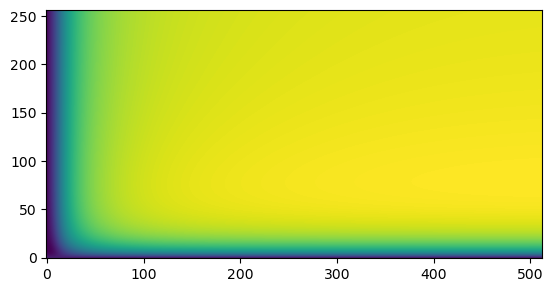

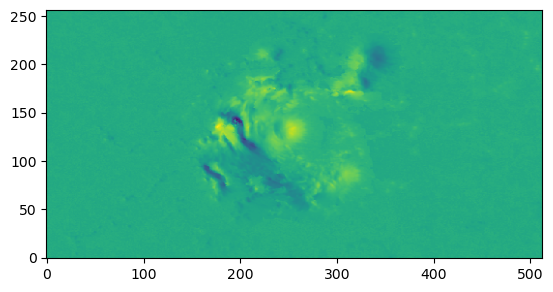

In [271]:
u = apply_fn(params, xt, yt, zt)
plt.figure()
plt.imshow(u[0, :, :, 0].transpose(), origin='lower')

plt.figure()
plt.imshow(b[0, :, :, 0].transpose(), origin='lower')

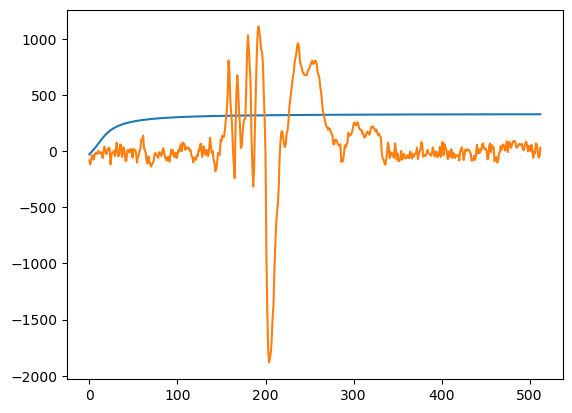

In [275]:
aaa = u[0, :, :, 0].transpose()
ccc = b[0, :, :, 0].transpose()

plt.plot(aaa[120, :]*2500)
plt.plot(ccc[120, :])

In [257]:
nc = 4
xb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=512)
yb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=256)
zb_p = jax.random.randint(subkey, (nc, 1), minval=0, maxval=256)
xb = jnp.array([[0]])
u = apply_fn(params, xb, yb_p, zb_p).squeeze()

In [258]:
u

Array([[[ 0.29175368,  0.39750975,  0.74877536,  6.8475943 ],
        [ 0.39607024,  0.50185007,  0.853117  ,  6.9413133 ],
        [ 0.6998817 ,  0.8058207 ,  1.1573482 ,  7.2136955 ],
        [ 2.3320317 ,  2.4310975 ,  2.7585719 ,  8.19558   ]],

       [[-0.30738902, -0.30787334, -0.30856118, -0.26543042],
        [-0.30742693, -0.30791208, -0.30859977, -0.2653585 ],
        [-0.30755454, -0.3080408 , -0.30872628, -0.2651914 ],
        [-0.29210502, -0.2925616 , -0.29312217, -0.24798831]],

       [[ 0.12015335,  0.12091787,  0.12256641,  0.11806986],
        [ 0.12046491,  0.12122466,  0.12286593,  0.11832495],
        [ 0.12097084,  0.1217173 ,  0.12333696,  0.11866359],
        [ 0.09576751,  0.09634009,  0.09755152,  0.09068099]]],      dtype=float32)

In [259]:
xb_m, yb_p_m, zb_p_m = np.meshgrid(xb, yb_p, zb_p, indexing='ij')

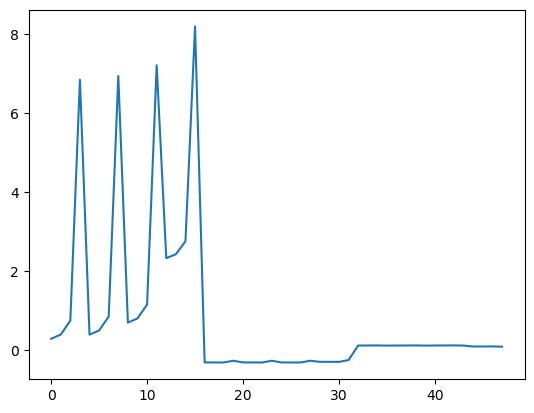

In [260]:
plt.plot(u.ravel())

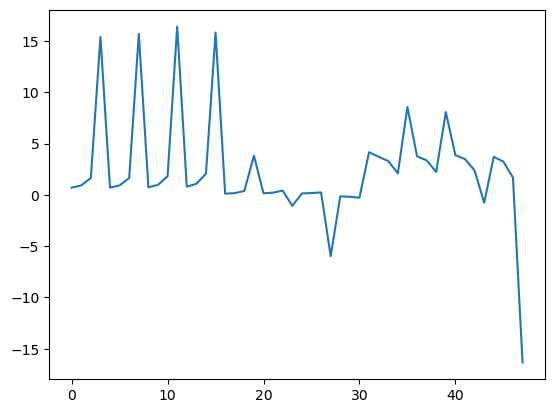

In [261]:
plt.plot(b[:, xb_m.ravel(), yb_p_m.ravel(), zb_p_m.ravel()].ravel())

In [211]:
k = b[:, 0, :, :]

In [212]:
k[:, yb_p_m.ravel(), zb_p_m.ravel()].ravel()

array([  0.69899333,   0.91685039,   1.64152324,  15.38521576,
         0.69800121,   0.91567832,   1.64201093,  15.67801666,
         0.73386973,   0.97439265,   1.80721426,  16.40563011,
         0.79535955,   1.07174873,   2.05279303,  15.81293392,
         0.11052569,   0.16371682,   0.37930089,   3.81057096,
         0.14967144,   0.21013246,   0.41321987,  -1.07692623,
         0.13381943,   0.1719041 ,   0.23343121,  -5.97059155,
        -0.146455  ,  -0.19139211,  -0.28258145,   4.15247583,
         3.70974946,   3.29227853,   2.09402156,   8.55581284,
         3.7582438 ,   3.36024094,   2.22857642,   8.06589603,
         3.86174679,   3.48794246,   2.37123966,  -0.77531302,
         3.70306778,   3.23655891,   1.68017936, -16.34046745])

In [113]:
bbb = k[0, ...]
bbb

array([[ 15.59000015,  35.0013504 ,  36.377491  , ...,   0.36098519,
          0.35527438,   0.34965375],
       [ 49.43000031,  31.31114388,  34.60973358, ...,   0.36141965,
          0.35569692,   0.35006467],
       [ 26.44000053,  33.457798  ,  33.72734833, ...,   0.36185512,
          0.35612041,   0.3504765 ],
       ...,
       [ 38.25999832,  40.8993721 ,  38.17782211, ...,   0.3601203 ,
          0.35443327,   0.3488358 ],
       [-34.06000137,  41.2420578 ,  37.99271011, ...,   0.36055198,
          0.35485306,   0.34924406],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [117]:
aaa.ravel().shape

(16,)

In [116]:
bbb[yb_p_m.ravel(), zb_p_m.ravel()].shape

(16,)

In [89]:
k = b[:, 0, :, :]
k[:, yb_p.ravel(), zb_p.ravel()].shape

(3, 64)

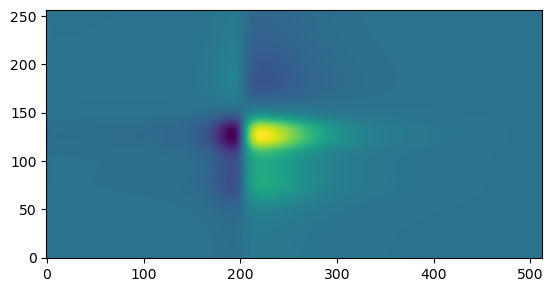

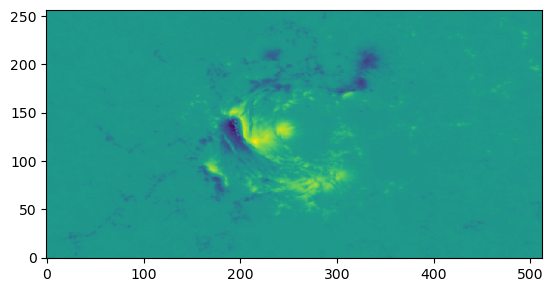

In [59]:
u = apply_fn(params, xt, yt, jnp.array([[0]])).squeeze()
bz_z0 = u[2, :, :]
plt.figure()
plt.imshow(bz_z0.transpose(), origin='lower')

plt.figure()
plt.imshow(b[2, :, :, 0].transpose(), origin='lower')

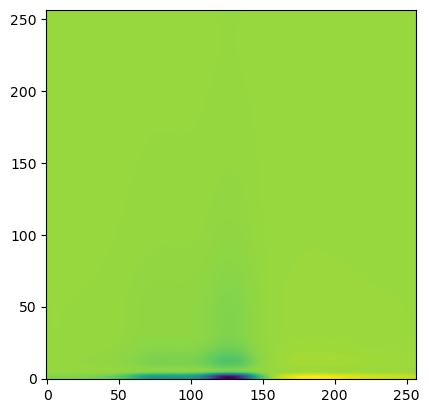

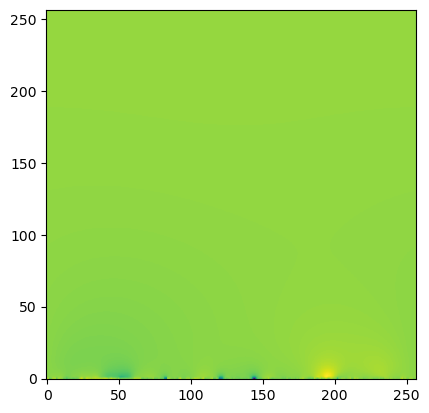

In [60]:
u = apply_fn(params, jnp.array([[0]]), yt, zt).squeeze()
bz_x0 = u[2, :, :]
plt.figure()
plt.imshow(bz_x0.transpose(), origin='lower')

plt.figure()
plt.imshow(b[2, 0, :, :].transpose(), origin='lower')